## Macro 2: Problem Sheet 1

### Exercise 1

> **Remark 1.** This notebook is structured as follows. First I define all necessary functions in a sort of abstract fashion. Then at the very end I call all functions to produce numerical results and plots.

In [1]:
from pathlib import Path
from functools import partial
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from joblib import Parallel
from joblib import delayed

sns.set_style("whitegrid")

In [2]:
DATA_PATH = Path("data/CNEF_PSID")

### Functions

In [3]:
def compose(f, g):
    """Composition of two functins.
    
    h(x) := f(g(x)) for all x
    
    """
    h = lambda x: f(g(x))
    return h

In [4]:
def get_yearly_variables(year):
    """Returns list and dict of relevant columns given year.
    
    Convert variables names to year specific names. For example instead
    of 'x11102' writes 'x1110285' for the year '85. Additionally add
    variable name for individual id.
    
    For details on variable names and more information seek the
    codebook: https://www.cnefdata.org/documentation/codebooks
    
    
    Args:
        year (int): Year. (Write 85 for 1985.)
        
    Returns:
        as_list (list): List of variable names.
        as_dict (dict): Dict of variable name translation to human
            readable form.
    
    """
    variables = {
        "x11102": "household",
        "i11113": "income",
        "d11105": "relationship_to_head",
        "d11101": "age",
        "d11109": "education",
        "e11101": "hours",
    }
    as_dict = {f"{key}{year}": value for key, value in variables.items()}
    as_dict = dict(as_dict, **{"x11101ll": "individual"})
    as_list = [f"{key}{year}" for key in variables.keys()]
    as_list.append("x11101ll")
    return as_dict, as_list

In [5]:
def load_data_given_year(year):
    """Load data and assign new columns given year.
    
    This already does some steps described in part 2 of exercise 1.
    
    Args:
        year (int): Year. (Write 85 for 1985.)
        
    Returns:
        df (pd.DataFrame): Data frame with columss
    
    """
    cols_mapper, cols = get_yearly_variables(year)

    df = pd.read_stata(DATA_PATH / f"pequiv{year}.dta", columns=cols)

    df = df.rename(columns=cols_mapper)
    df = df.set_index(["household", "individual"])
    df = df.dropna(how="all")
    df = df.assign(
        **{
            "year": year,
            "relationship_to_head": df.relationship_to_head.str.split(" ").apply(
                lambda s: s[0]
            ),
        }
    )
    df = df.convert_dtypes()
    return df

In [6]:
def clean_data(df):
    """Clean data frame.
    
    This does most steps described in part 2 of exercise 1.
    
    Args:
        df (pd.DataFrame): Frame produced by :func:`load_data_given_year`.
        
    Returns:
        df (pd.DataFrame): Cleaned data frame.
    
    """
    TEN_PERCENT_OF_ANNUAL_FULLTIME_HOURS = 208

    df = df.query("relationship_to_head in ['head', 'partner']")
    df = df.assign(
        **{
            "is_single": df.relationship_to_head.groupby("household").transform(
                lambda x: set(x) != {"head", "partner"}
            )
        }
    )
    df = df.query("is_single == False")

    total = df.groupby(by="household")[["hours"]].sum()

    df = df.query("relationship_to_head == 'head'")
    df = df.reset_index(level="individual")
    df = df.assign(**{"hours": total.hours})
    df = df.set_index("individual")

    df = df.query("25 <= age < 56")
    df = df.query("hours >= @TEN_PERCENT_OF_ANNUAL_FULLTIME_HOURS")
    df = df.query("income > 0")

    df = df.assign(**{"income": np.log(df.income)})

    df = df.drop(["relationship_to_head", "is_single", "hours"], axis=1)
    df = df.set_index("age", append=True)
    df.index = df.index.set_names(["household", "age"])
    df = df.dropna(how="any")
    return df

In [7]:
def load_and_clean_data(n_jobs=1, load_from_disc=False):
    """Load, clean and merge data for years 1980 to 1997.
    
    Since loading and cleaning the data is time consuming there is
    a check if clean data is already available, otherwise use multiple cores.
    
    Args:
        n_jobs (int): Number of cores to use for parallelized data cleaning.
        load_from_disc (bool): Should the dataset be loaded from disc if available.
            Default False.
    
    Returns:
        df (pd.DataFrame): Cleaned and merged data frame with index ['household', 'year']
            and columns 'income', 'age', 'education' and 'work'. Column 'income' is float
            while all other columns are category.
    
    """
    clean_data_path = DATA_PATH.parent / "clean_data.csv"
    if load_from_disc and clean_data_path.exists():
        df = pd.read_csv(clean_data_path)
    else:
        _load_and_clean = compose(clean_data, load_data_given_year)
        dfs = Parallel(n_jobs, prefer="processes")(
            delayed(_load_and_clean)(year) for year in range(80, 98)
        )
        df = pd.concat(dfs).sort_index().reset_index()

    df = df.astype(
        {
            "age": int,
            "household": int,
            "income": float,
            "education": "category",
            "year": int,
        }
    )
    df = df.drop_duplicates(subset=["household", "age"], keep="first")
    return df

In [8]:
def fit_dummy_regression(df):
    """Fit dummy regression on data in df.
    
    In the formula object C() tells statsmodels to use the variable as
    categorical variable.
    
    """
    df = df.copy().astype({"age": "category", "year": "category"})
    model = ols("income ~ C(year) + C(age) + C(education)", data=df)
    model = model.fit()
    return model

In [9]:
def estimate_quantities_approach_4(df):
    """Estimate quantities using approach in part 4.
    
    The correction for year and birthyear here is not *correct*.
    
    Args:
        df (pd.DataFrame): Cleaned data with residuals.
    
    Returns:
        quantities (pd.DataFrame): Estimates of rho, sigma_eps^2 and sigma_mu_tau^2.
        var (pd.DataFrame): Sample variances.

    """

    def _estimate(data, col):
        var = data.groupby("age")[col].var()
        _rho = (var.loc[55] - var.loc[40]) / (var.loc[40] - var.loc[25])
        rho = _rho ** (1 / 30)
        gamma = rho ** 2 * (1 - rho ** 30) / (1 - rho ** 2)

        sigma_eps = (var.loc[40] - var.loc[25]) / gamma
        sigma_mu_tau = var.loc[25] - sigma_eps
        return rho, sigma_eps, sigma_mu_tau

    index = ["rho", "sigma_epsilon", "sigma_mu_tau"]
    columns = ["baseline", "year", "birthyear"]
    quantities = pd.DataFrame(columns=columns, index=index)

    df = df.query("age in [25, 40, 55]")[["age", "residuals", "year"]]
    df = df.assign(**{"birthyear": df.year - df.age})

    # correct for year and birth year using dummies
    df = df.assign(
        **{"residuals-year": ols("residuals ~ C(year)", data=df).fit().resid}
    )
    df = df.assign(
        **{"residuals-birthyear": ols("residuals ~ C(birthyear)", data=df).fit().resid}
    )

    quantities.loc[:, "baseline"] = _estimate(df, "residuals")
    quantities.loc[:, "year"] = _estimate(df, "residuals-year")
    quantities.loc[:, "birthyear"] = _estimate(df, "residuals-birthyear")
    quantities = quantities.reset_index().rename({"index": "symbol"}, axis=1)

    var = df.groupby("age")["residuals"].var()
    return quantities, var

In [10]:
def predict_residual_variance(part4, age):
    """Predict residual variance.
    
    Predicts residual variance given `age` using estimates from part 4.
    
    Args:
        part4 (pd.DataFrame): Output from :func:`estimate_quantities_part4`.
            Has columns [symbol, baseline, sample-year, birth-year].
        age (int or int-array-like): age for which to predict the residual
            variance
            
    Returns:
        prediction (pd.DataFrame): Variance estimate with rows corresponding to
            `age` and columns corresponding to the columns of `part4`.
    
    """

    def _estimate(h, col):
        """Variance of residual predicted by model."""
        h = h - 24
        rho = part4.loc[0, col]
        sigma_e = part4.loc[1, col]
        sigma_mu_tau = part4.loc[2, col]
        out = sigma_e * (1 - rho ** (2 * h)) / (1 - rho ** 2) + sigma_mu_tau
        return out

    cols = part4.columns.drop("symbol")
    prediction = pd.DataFrame(columns=cols, index=age)
    for h, col in product(age, cols):
        prediction.loc[h, col] = _estimate(h, col)

    return prediction

In [11]:
def plot_part4(df, part4):
    """Plot results from part 4."""
    data = df.set_index("age").groupby("age")[["residuals"]].var()
    data = data.rename({"residuals": "true"}, axis=1)

    predicted = predict_residual_variance(part4, data.index.values)

    df = pd.concat((data, predicted), axis=1)
    df = df.assign(**{"age": data.index})
    df = df.melt(id_vars="age", var_name="type", value_name="value")
    df = df.convert_dtypes()

    fig, ax = plt.subplots(1)
    fig.set_size_inches(13, 7)

    p = sns.lineplot(
        x="age", y="value", hue="type", data=df, ax=ax, linewidth=2, legend="brief",
    )

    ax.set(ylabel="Cross-sectional variance", xlabel="Age")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(13)
    ax.yaxis.label.set_size(13)
    return None

In [12]:
def estimate_quantities_approach_5(df, var):
    """Estimate quantities using approach in part 5.
    
    Args:
        df (pd.DataFrame): Cleaned data with residuals.
        var (pd.DataFrame): Variance output from :func:`estimate_quantities_approach_4`.
        
    Returns:
        quantities (pd.DataFrame): Estimated values.
    
    """
    forty_year_old_households = df.query("age == 40")["household"]
    df = df.query("household in @forty_year_old_households")

    # compute (sample) covariances
    combinations = [(40, 39), (40, 38), (40, 37)]
    cov = pd.DataFrame(index=pd.MultiIndex.from_tuples(combinations))
    for comb in combinations:

        _df = df[["household", "age", "residuals"]].query("age in @comb")
        idx = _df.groupby("household")["age"].transform(
            lambda x: set(x) == set(comb) and len(x) == 2
        )
        _df = _df.loc[idx, :].set_index(["household", "age"])

        _cov = _df.unstack(level="age").cov().values[0, 1]
        cov.loc[comb, "cov"] = _cov

    # compute quantities
    rho = (
        (cov.loc[(40, 37),] - cov.loc[(40, 38)])
        / (cov.loc[(40, 38),] - cov.loc[(40, 39)])
    )[0]

    sigma_eps = (
        (cov.loc[(40, 37),] - cov.loc[(40, 37),])[0]
        * (1 - rho ** 2)
        / (rho * (rho - 1) * (rho ** 29 + 1))
    )
    sigma_mu = cov.loc[(40, 39),][0] - sigma_eps * rho * (1 - rho ** 30) / (
        1 - rho ** 2
    )
    sigma_tau = var.loc[25] - sigma_mu - sigma_eps

    quantities = (
        pd.DataFrame(
            [rho, sigma_eps, sigma_mu, sigma_tau],
            columns=["part5"],
            index=["rho", "sigma_epsilon", "sigma_mu", "sigma_tau",],
        )
        .reset_index()
        .rename({"index": "symbol"}, axis=1)
    )
    return quantities

In [30]:
def estimate_rho_approach_iv(df, n_jobs=1):
    """Estimate rho using an instrumental variable approach.
    
    Regression equation:
        
        (1)   x_{ih}* = rho x_{i, h-1}* + error
        
    Equation (1) has an endogeneity problem, hence we will construct
    a valid instrument z_{i, h-1} for x_{i, h-1}* and estimate rho
    using 2SLS.
    
    (!) A minimum requirement for this to work is that for *some* number
    of observations x_{ih}* AND x_{i, h-1}* is observed.
    
    Args:
        df (pd.DataFrame): Cleaned data with residuals.
        n_jobs (int): Number of cores to use for parallelized data cleaning.
        
    Returns:
    
        ... MISSING ...
    
    """
    # create instruments
    def _create_instrument_or_return_nan(household, age, df):
        try:
            instrument = (
                df.loc[(household, age - 1), "residuals"]
                - df.loc[(household, age - 2), "residuals"]
            )
        except KeyError:
            instrument = np.nan

        try:
            lagged_residual = df.loc[(household, age - 1), "residuals"]
        except KeyError:
            lagged_residual = np.nan

        return instrument, lagged_residual

    df = df.set_index(["household", "age"])

    to_parallelize = partial(_create_instrument_or_return_nan, **{"df": df})
    results = Parallel(n_jobs, prefer="processes")(
        delayed(to_parallelize)(household, age) for household, age in df.index
    )
    results = pd.DataFrame(
        results, columns=["instrument", "lagged_residuals"], index=df.index
    )

    df = pd.concat((df, results), axis=1)
    df = df.dropna(how="any")

    # prepare data sets
    df = df.reset_index()
    df = df.astype({"household": "category"})

    fixed_effect_dummies = pd.get_dummies(df["household"], prefix="hh")

    X = pd.concat((df[["lagged_residuals"]], fixed_effect_dummies), axis=1).values
    Z = pd.concat((df[["instrument"]], fixed_effect_dummies), axis=1).values
    y = df[["residuals"]].values

    # iv regression
    beta = np.linalg.inv(Z.T @ X) @ Z.T @ y  # this can be optimized i know

    quantity = (
        pd.Series(beta[0], index=["rho"], name="part6")
        .to_frame()
        .reset_index()
        .rename({"index": "symbol"}, axis=1)
    )
    return quantity

In [14]:
def combine_parts(part4, part5, part6):
    """Combine results from part4 to part6 in one data frame."""
    df = part4.merge(part5, on="symbol", how="outer", suffixes=("_part4", "_part5"))
    df = df.merge(part6, on="symbol", how="outer", suffixes=("_part4", "_part5"))
    df = df.convert_dtypes()
    return df

## Actual Computation

In [15]:
df = load_and_clean_data(n_jobs=4, load_from_disc=True)

### Fit Model and use Residuals

In [16]:
model = fit_dummy_regression(df)

In [17]:
df = df.assign(**{"residuals": model.resid})

### Part 4

In [18]:
part4, var = estimate_quantities_approach_4(df)

In [19]:
part4

,symbol,baseline,year,birthyear
0,rho,1.019941,1.019601,1.014593
1,sigma_epsilon,0.001355,0.001307,0.001485
2,sigma_mu_tau,0.184251,0.184452,0.182031


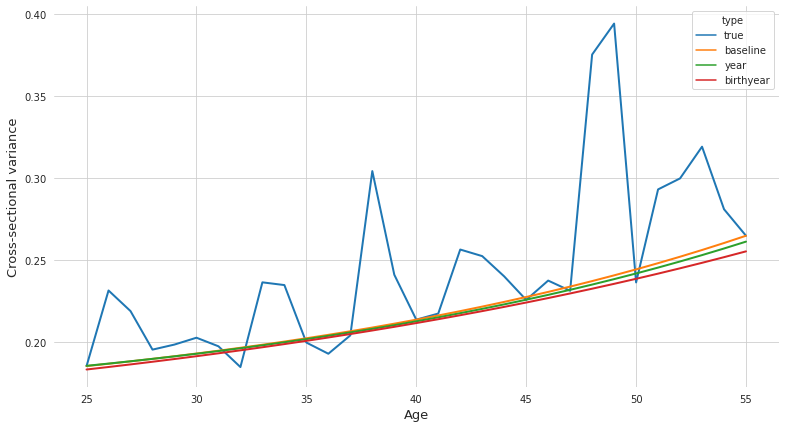

In [20]:
plot_part4(df, part4)

### Part 5

In [21]:
part5 = estimate_quantities_approach_5(df, var)

In [22]:
part5

,symbol,part5
0,rho,10.015074
1,sigma_epsilon,-0.000000
2,sigma_mu,0.160790
3,sigma_tau,0.024816


### Part 6

In [31]:
part6 = estimate_rho_approach_iv(df, n_jobs=4)

## Combined Results

In [32]:
result = combine_parts(part4, part5, part6)

In [33]:
result

,symbol,baseline,year,birthyear,part5,part6
0,rho,1.019941,1.019601,1.014593,10.015074,0.134981
1,sigma_epsilon,0.001355,0.001307,0.001485,-0.0,<NA>
2,sigma_mu_tau,0.184251,0.184452,0.182031,<NA>,<NA>
3,sigma_mu,<NA>,<NA>,<NA>,0.16079,<NA>
4,sigma_tau,<NA>,<NA>,<NA>,0.024816,<NA>
